# **Dataset Preparation:**


In [1]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-08-22 18:42:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-08-22 18:42:36--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  20.3MB/s    in 41s     

2024-08-22 18:43:18 (18.5 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2024-08-22 18:43:18--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving w

In [2]:
import os

input_dir = "/content/images"
target_dir = "/content/annotations/trimaps"

img_size = (128, 128)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from typing import Tuple, List

import numpy as np


class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size: int, img_size: Tuple[int, int], input_img_paths: List[str], target_img_paths:List[str]):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths


    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_start_idx = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[batch_start_idx : batch_start_idx + self.batch_size]
        batch_target_img_paths = self.target_img_paths[batch_start_idx : batch_start_idx + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for image_idx, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[image_idx] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for image_idx, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[image_idx] = np.expand_dims(img, 2)
            y[image_idx] -= 1
        return x, y

In [11]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
val_input_img_paths = input_img_paths[:val_samples]
val_target_img_paths = target_img_paths[:val_samples]
train_input_img_paths = input_img_paths[val_samples:]
train_target_img_paths = target_img_paths[val_samples:]

val_gen = DataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)
train_gen = DataGenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)

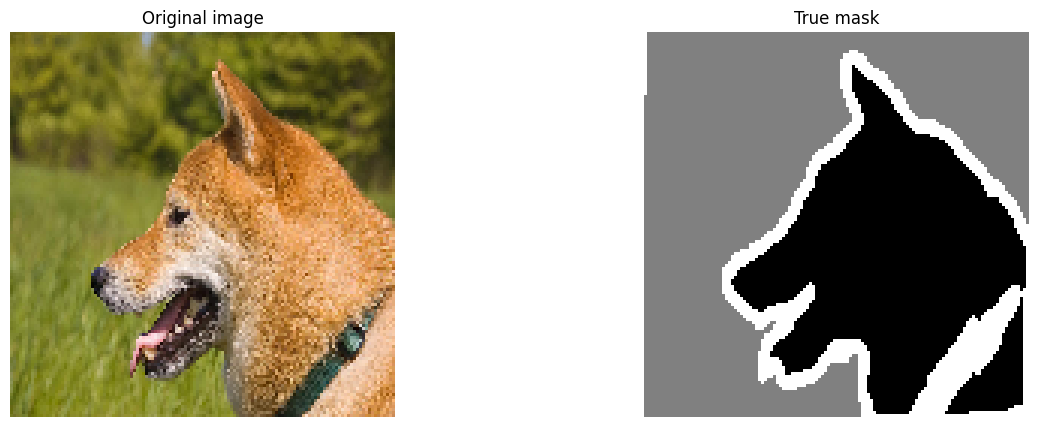

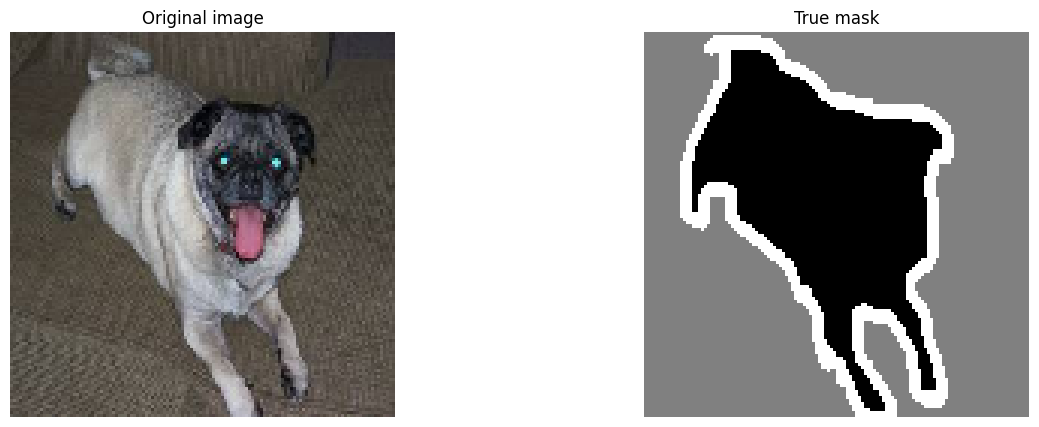

In [27]:
import matplotlib.pyplot as plt


def show_dataset_image(generator: DataGenerator, batch_idx: int, image_idx: int):
    x_val, y_val = generator[batch_idx]
    input_image = x_val[image_idx]
    true_mask = y_val[image_idx]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(input_image.astype('uint8'))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("True mask")
    plt.imshow(true_mask, cmap="gray")
    plt.axis('off')
    plt.show()


show_dataset_image(generator=train_gen, batch_idx=0, image_idx=5)
show_dataset_image(generator=val_gen, batch_idx=5, image_idx=10)

In [28]:
from tensorflow.keras import layers

def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    return x

In [29]:
def downsample_block(x, n_filters):
    conv = double_conv_block(x, n_filters)
    pool = layers.MaxPool2D((2, 2), padding='same')(conv)
    pool = layers.Dropout(0.2)(pool)
    return conv, pool

In [30]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.2)(x)
    x = double_conv_block(x, n_filters)
    return x

In [31]:
def get_model(img_size: Tuple[int, int], num_classes: int):
    input = layers.Input(shape=(*img_size, 3))
    conv1, pool1 = downsample_block(input, 64)
    conv2, pool2 = downsample_block(pool1, 128)
    conv3, pool3 = downsample_block(pool2, 256)
    conv4, pool4 = downsample_block(pool3, 512)

    bottleneck = double_conv_block(pool4, 1024)

    up6 = upsample_block(bottleneck, conv4, 512)
    up7 = upsample_block(up6, conv3, 256)
    up8 = upsample_block(up7, conv2, 128)
    up9 = upsample_block(up8, conv1, 64)

    output = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(up9)

    unet_model = keras.Model(input, output, name="U-Net")

    return unet_model

In [32]:
unet_model = get_model(img_size, num_classes)
unet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
epochs = 20
training_history = unet_model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 172s 548ms/step - accuracy: 0.5604 - loss: 2.1444 - val_accuracy: 0.7374 - val_loss: 0.6616
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 94s 469ms/step - accuracy: 0.7570 - loss: 0.6284 - val_accuracy: 0.7948 - val_loss: 0.5247
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 94s 468ms/step - accuracy: 0.7943 - loss: 0.5218 - val_accuracy: 0.7937 - val_loss: 0.5096
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 94s 468ms/step - accuracy: 0.8251 - loss: 0.4486 - val_accuracy: 0.8461 - val_loss: 0.3983
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 142s 470ms/step - accuracy: 0.8393 - loss: 0.4140 - val_accuracy: 0.8517 - val_loss: 0.3865
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 144s 476ms/step - accuracy: 0.8494 - loss: 0.3928 - val_accuracy: 0.8542 - val_loss: 0.3886
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 95s 473ms/step - accuracy: 0.8534 - loss: 0.3812 - val_accuracy: 0.8685 - val_loss: 0.3450
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 94s 468ms/step - accuracy: 0.8650 - loss: 0.3527 - 

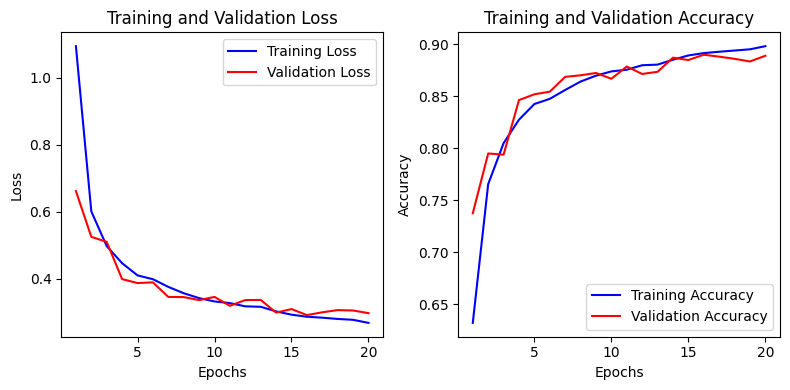

In [33]:
import matplotlib.pyplot as plt

train_loss = training_history.history['loss']
train_acc = training_history.history['accuracy']
val_loss = training_history.history['val_loss']
val_acc = training_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


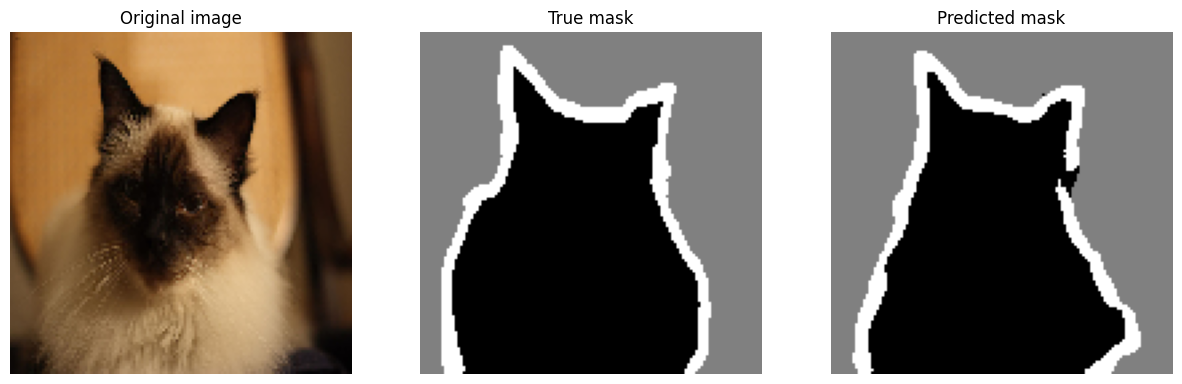

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


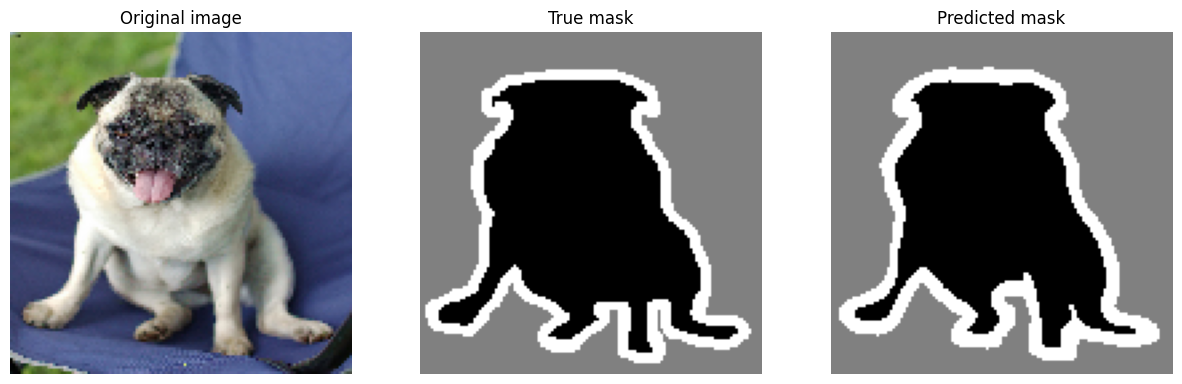

In [52]:
def show_predicted_image(batch_idx: int, image_idx: int):
    x_val, y_val = val_gen[batch_idx]
    predictions = unet_model.predict(x_val)
    input_image = x_val[image_idx]
    true_mask = y_val[image_idx]
    predicted_mask = np.argmax(predictions[image_idx], axis=-1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.imshow(input_image.astype('uint8'))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("True mask")
    plt.imshow(true_mask, cmap="gray")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Predicted mask")
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis('off')

    plt.show()


show_predicted_image(batch_idx=0, image_idx=0)
show_predicted_image(batch_idx=0, image_idx=8)